In [1]:
# Scoring networks
# Using RBFENN output connected matrix, with SEM predictions (not scaled) to determine total SEM from 
# reference node to each node
# dijkstra algorithm
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.dijkstra.html

#Input N*N sparse distance matrix (SEM)

In [2]:
# This is round about. Better to get standard data format from source.
# rbfenn_network_output.txt describes all edges in graph. Index refers to index in (new_)links_file.in
# Pair of indices can be traced back to cluster_pair_preds.csv to find SEM of edge (before transformation)
# Finally construct sparse matrix 

In [3]:
network_path = "../networks/very_large-22-06-28/"
rbfenn_output = f"{network_path}rbfenn_network_output_useful.txt"

In [4]:
#Reading all data
sem_scores = []
row_idx = []
col_idx = []
sem_scores_normalised = []
labeldict = {}

with open (rbfenn_output, "r") as file:
    for line in file.readlines():
        line = line.rstrip()
        line = line.split(" ")
        sem_scores.append(float(line[-1]))
        sem_scores_normalised.append(float(line[-2]))
        row_idx.append(int(line[0]))
        col_idx.append(int(line[1]))
        
        labeldict[int(line[0])] = line[2]
        labeldict[int(line[1])] = line[3]
        
shape = max(max(row_idx), max(col_idx)) + 1

In [5]:
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse.csgraph import shortest_path

In [6]:
graph = csr_matrix((sem_scores, (row_idx, col_idx)), shape=(shape,shape))

In [7]:
print("edges from RBFENN")
#print(graph)

edges from RBFENN


In [197]:
# Finds the node with greatest number of edges
# Assumed to be origin of graph
# Can define this as the reference ligand
all_nodes_in_graph = (row_idx+col_idx)
counts = []
for i in range(shape):
    counts.append((i,all_nodes_in_graph.count(i)))
best_connected_node = max(counts, key=lambda x: x[1])
worst_connected_node = min(counts, key=lambda x: x[1])

print(f"index: {best_connected_node[0]}, edges: {best_connected_node[1]}")
print(f"index: {worst_connected_node[0]}, edges: {worst_connected_node[1]}")
#origin = best_connected_node[0]
#origin = worst_connected_node[0]
origin = 4

index: 52, edges: 29
index: 12, edges: 1


In [198]:
dist_matrix, predecessors = shortest_path(csgraph=graph,
                                          directed=False,
                                          indices=origin,
                                          return_predecessors=True,
                                          method="D",
                                          unweighted = False
                                         )


dist_matrix_unweighted, predecessors_unweighted = shortest_path(csgraph=graph,
                                          directed=False,
                                          indices=origin,
                                          return_predecessors=True,
                                          method="D",
                                          unweighted = True
                                         )

In [199]:
"""
print("Calculated Dijkstra scores (shortest path to node = 0)")
for counter, line in enumerate(dist_matrix):
    print(counter, line)
"""

'\nprint("Calculated Dijkstra scores (shortest path to node = 0)")\nfor counter, line in enumerate(dist_matrix):\n    print(counter, line)\n'

In [200]:
#print("predecessors: can be used to determined\nwhich nodes were connected \nin shortest path\n")
shortest_path_edges = []
for counter,line in enumerate(predecessors):
    shortest_path_edges.append((counter, line))
shortest_path_edges.remove((origin, -9999))
#shortest_path_edges

In [201]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [202]:
second_smallest = dist_matrix[np.argpartition(dist_matrix, 2)][1]
node_colours = dist_matrix.copy()
node_colours[node_colours == 0. ] = second_smallest

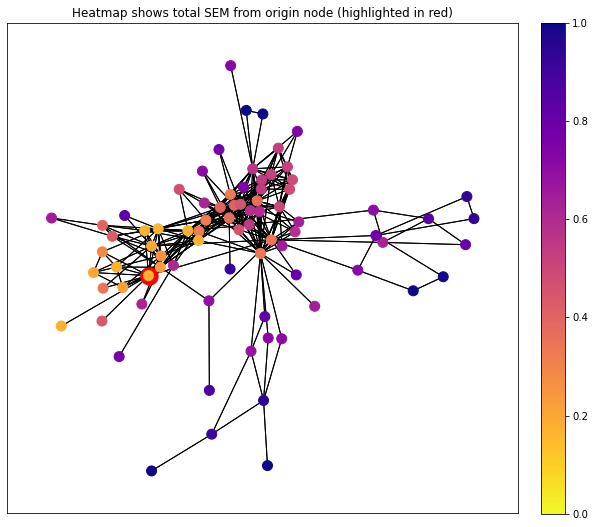

In [203]:
# Visualise RBFENN network, without molecules

fig = plt.gcf()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
fig.set_size_inches(10,10)


G = nx.from_scipy_sparse_matrix(graph)

pos = nx.spring_layout(G, seed=4)
nx.draw_networkx_edges(G, pos, width=1) # draw all edges
#nx.draw_networkx_edges(G, pos, edgelist=shortest_path_edges, width=3, edge_color="r") # draw highlighted edges


nx.draw_networkx_nodes(G, pos, nodelist=[origin], node_size=300, node_color="r") # Highlight origin node


#variables
cmap="plasma_r"
vmin = 0
vmax = 1 #Strictly defining min and max keeps networks comparable
         #vmax = np.amax(node_colours)

nx.draw_networkx(G, pos,
                 node_color=node_colours, cmap=cmap,vmin=vmin, vmax=vmax,
                 labels=labeldict, with_labels=False,
                 node_size=100, node_shape="o")

ax.set_title("Heatmap shows total SEM from origin node (highlighted in red)")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm,fraction=0.044, pad=0.04)

plt.show()

In [204]:
# Simple analysis
# average edge score
# Number of edges
# Average min SEM path
# Average number of edges in path

# distibutions of each

In [205]:
# Average edge score
print(f"Average sem (pred): {round(sum(sem_scores)/len(sem_scores), 3)}")
print(f"Average sem (normalised): {round(sum(sem_scores_normalised)/len(sem_scores_normalised), 3)}")
print()
print(f"Number of edges: {len(sem_scores)}")
print(f"Number of nodes: {shape}")
print(f"Avg edges per node: {round(len(sem_scores)/shape, 3)}")
print()
print("Dijkstra sem score")
#dist_matrix includes origin = 0 distance
#node_colours has set origin distance to the min of remaining
#should remove this edge in calculations
print(f"min: {round(np.amin(node_colours), 3)}")
print(f"max: {round(np.amax(dist_matrix), 3)}")
print(f"mean: {round(np.mean(dist_matrix), 3)}")
print()
print("Number of edges from reference")
print(f"max: {round(np.amax(dist_matrix_unweighted), 3)}")
print(f"mean: {round(np.mean(dist_matrix_unweighted), 3)}")

Average sem (pred): 0.267
Average sem (normalised): 0.541

Number of edges: 312
Number of nodes: 80
Avg edges per node: 3.9

Dijkstra sem score
min: 0.165
max: 1.268
mean: 0.585

Number of edges from reference
max: 5.0
mean: 2.325


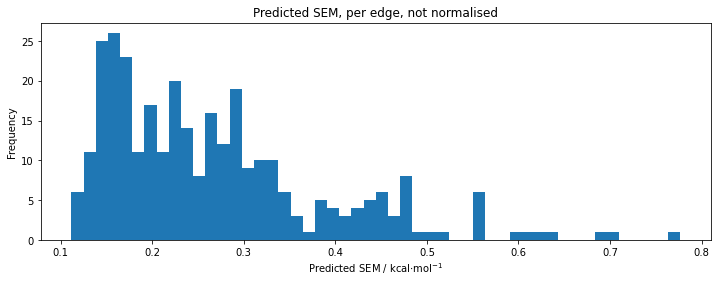

In [206]:
# Distribution of sem predictions

# use some simple plotting functions to display the SF distribution.
fig, ax = plt.subplots(figsize=(12, 4)) # easier for controlling figure dims

# make the histogram.
ax.hist(sem_scores, bins=50) # tweak n bins here.

# do some further formatting.
ax.set_title("Predicted SEM, per edge, not normalised")
ax.set_xlabel("Predicted SEM / kcal$\cdot$mol$^{-1}$")
ax.set_ylabel("Frequency")


plt.show()

In [207]:
import seaborn as sns

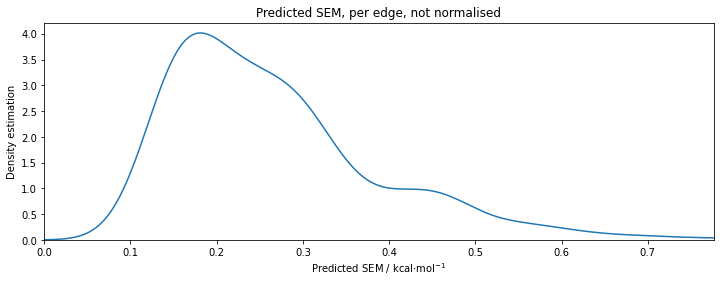

In [208]:
# we can also make it a bit prettier, e.g. using a density plot. Seaborn makes this quite straightforward. 
fig, ax = plt.subplots(figsize=(12, 4)) # easier for controlling figure dims

sns.kdeplot(sem_scores, ax=ax)

# do some further formatting.
ax.set_title("Predicted SEM, per edge, not normalised")
ax.set_xlabel("Predicted SEM / kcal$\cdot$mol$^{-1}$")
ax.set_ylabel("Density estimation")

ax.set_xlim(0, max(sem_scores)) # cut off the x values; SEM < 0 is confusing.

plt.show()

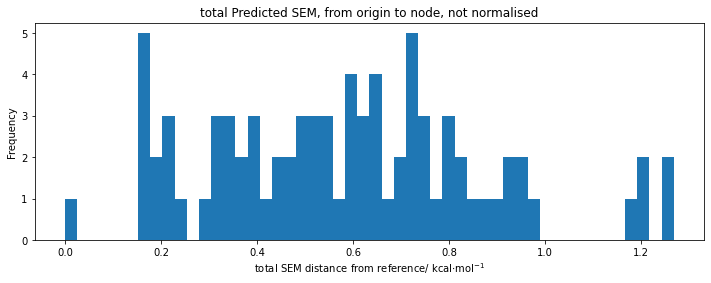

In [209]:
# Distribution of Dijkstra scores

# Distribution of sem predictions

# use some simple plotting functions to display the SF distribution.
fig, ax = plt.subplots(figsize=(12, 4)) # easier for controlling figure dims

# make the histogram.
ax.hist(dist_matrix, bins=50) # tweak n bins here.

# do some further formatting.
ax.set_title("total Predicted SEM, from origin to node, not normalised")
ax.set_xlabel("total SEM distance from reference/ kcal$\cdot$mol$^{-1}$")
ax.set_ylabel("Frequency")


plt.show()

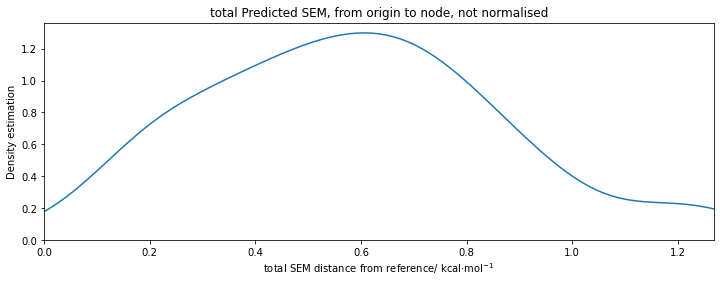

In [210]:
fig, ax = plt.subplots(figsize=(12, 4)) # easier for controlling figure dims

sns.kdeplot(dist_matrix, ax=ax)

# do some further formatting.
ax.set_title("total Predicted SEM, from origin to node, not normalised")
ax.set_xlabel("total SEM distance from reference/ kcal$\cdot$mol$^{-1}$")
ax.set_ylabel("Density estimation")

ax.set_xlim(0, max(dist_matrix)) # cut off the x values; SEM < 0 is confusing.

plt.show()

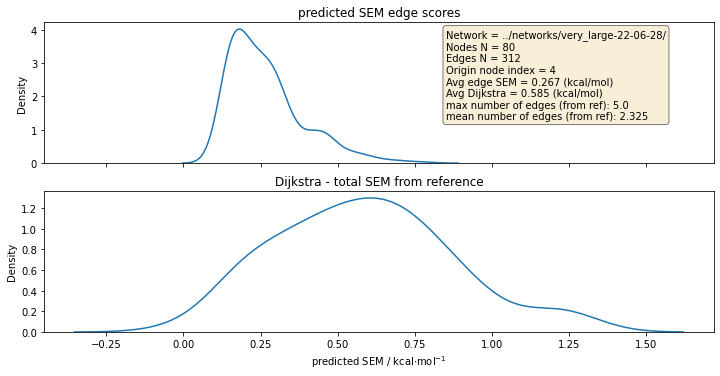

In [211]:
#Combing plots, sharing x
fig, (ax1,ax2) = plt.subplots(2, figsize=(12, 4), sharex=True) # easier for controlling figure dims

#fig.suptitle('Predicted SEM Scores (not normalised)',fontsize=16)

ax1.set_title("predicted SEM edge scores")
sns.kdeplot(sem_scores, ax=ax1)

ax2.set_title("Dijkstra - total SEM from reference")
sns.kdeplot(dist_matrix, ax=ax2)
ax2.set_xlabel("predicted SEM / kcal$\cdot$mol$^{-1}$")

note = f"""Network = {network_path}
Nodes N = {len(dist_matrix)}
Edges N = {len(sem_scores)}
Origin node index = {origin}
Avg edge SEM = {round(sum(sem_scores)/len(sem_scores), 3)} (kcal/mol)
Avg Dijkstra = {round(np.mean(dist_matrix), 3)} (kcal/mol)
max number of edges (from ref): {round(np.amax(dist_matrix_unweighted), 3)}
mean number of edges (from ref): {round(np.mean(dist_matrix_unweighted), 3)}"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.6, 0.95, note, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top',
         bbox=props)

plt.subplots_adjust(top=1.2)
plt.show()